# Signatures of mutational processes in human cancer

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from IPython.display import Markdown as md

In [2]:
sns.set_style(style="whitegrid")
sns.set( font_scale = 1.2 )

TITLE_SIZE = 18
LABEL_SIZE = 16
LEGEND_SIZE = 14

### 1) Proposed tasks for the project

*(Below the proposed tasks can be read. Completed tasks are marked with green color, uncompleted tasks are marked with red color.)*

**Understanding the goals of the project**


<span style="color:green"> 0) To get an idea about the basic aims of the project, read [1] and [2]. Many more publications are available on the topic [3-6], but the main concepts are best described in the papers mentioned above. Make sure you understand what a mutational catalog means.</span>


**Downloading the necessary data**


<span style="color:green"> 1) Lists of somatic mutations for different cancer types, for many samples are included with the task description.</span>

<span style="color:green"> 2) The human reference genome version hg19. Use this website and download the reference genome for each chromosome separately. (Download the files named "chr[chromosome_name].fa.gz".) These files are compressed FASTA files. Make sure you understand their structure.</span>


**Determining sequence context for an arbitrary genomic position**


<span style="color:green"> 3) Define the genomic position by the name of the chromosome and the position of the base on that chromosome (chr:pos). (Genomic positions are not absolute, the numbering starts from 1 for each chromosome.)</span>

<span style="color:green"> 4) Search the above downloaded reference genome file of the appropriate chromosome and find the nucleobase at the given position. Also get the bases immediately before and after the given genomic position.</span>

<span style="color:green"> 5) To check your results for a few cases, you can use the UCSC Genome Browser. (For example, sequence context for chrY:6736166 is CAT.)</span>


**Creating a mutational catalog for the 5 lists of somatic mutations separately**


<span style="color:green"> 6) Filter the tables so that only SNP variants are kept (insertions and deletions are ignored).</span>

<span style="color:green"> 7) Get sequence context for the remaining mutations with the method designed in the previous task. (Check if the base you find there is the same as the base listed in the Reference_Allele field.)</span>

<span style="color:red"> 8) For each sample in the set (indicated by the sample ID in field Tumor_Sample_UUID), collect the mutations and categorize them to 96 mutational categories based on the reference and the alternate (field Tumor_Seq_Allele2) allele and the sequence context.</span>
    
<span style="color:red"> 9) Create a mutational catalog $C$ (a matrix), where $C_{ij}$ is the number of mutations found in sample $j$ in the mutational category $i$. (Samples are listed as columns, mutational categories as rows.)</span>

<span style="color:red"> 10) Do this separately for the 5 different cancer types.</span>


**Performing non-negative matrix factorization to extract signatures**


<span style="color:red"> 11) Extract mutational signatures by using non-negative matrix factorization on the mutational catalogs separately. Choose the minimal set of signatures for each catalog that reconstructs the original matrix "fairly well". (Make sure to address this issue in a quantitative manner.)</span>
    
<span style="color:red"> 12) Play around with different types of normalization and rescaling of the data. (For example, what happens if you normalize the mutational catalog so that the total number of mutations for a single sample sum to 1. What happens if the number of the mutations in a given mutational type sum to 1 across samples?) Do you get different results? Discuss!</span>

<span style="color:red"> 13) Perform signature extraction for all 5 mutational catalogs.</span>


**Condensing signatures**


<span style="color:red"> 14) Once your signatures are extracted from all 5 mutational catalogs, try clustering them using different methods. Try to decrease the total number of signatures by combining "reasonably similar" ones. Make sure your criteria are clearly explained. Also, be very specific about how you actually "combine" similar signatures.</span>

<span style="color:red"> 15) Show the most dominant consensus signatures and their contributions for each cancer type.</span>


### 2) Understanding the project

As a first step it was necessary to understand the main points of the project. For this purpose a presentation was made and held on the last meeting. The presentation can be found in the folder (*dslab_intro.pdf*). Corresponding articles also can be found in the folder:

[1] Alexandrov LB, et al. (2013) Signatures of mutational processes in human cancer. Nature 500(7463):415–21. (Filename: *ref1.pdf*)

[2] Nik-Zainal S, et al. (2012) Mutational processes molding the genomes of 21 breast cancers. Cell 149(5):979–93. (Filename: *ref2.pdf*)

### 3) Data exploration

In this chapter we will explore the data files which contain somatic mutations for different cancer types (files are attached to the project). For this purpose a function

<center>read_maf_into_dataframe( relativePath, fileName, variantType, columnsToKeep=None )</center>

will be defined for reading the files in a proper way and load them into Pandas Dataframes. To increase efficiency (memory usage and time usage) we will keep only those columns which are necessary to perform further tasks.

File names and cancer types:

| File name | Type of cancer |
|-----------:|:-------------:|
| KIRC.maf | kidney renal clear cell carcinoma |
| LUAD.maf | lung adenocarcinoma |
| LUSC.maf | lung squamous cell carcinoma |
| OV.maf | ovarian cancer |
| PRAD.maf | prostate adenocarcinoma |

Column names in files (necessary columns are marked with bold):

- Hugo_Symbol
- Entrez_Gene_Id
- Center
- Ncbi_Build
- **Chrom**
- **Start_Position**
- **End_Position**
- Strand
- Variant_Classification
- Variant_Type
- **Reference_Allele**
- Tumor_Seq_Allele1
- **Tumor_Seq_Allele2**
- Dbsnp_Rs
- Dbsnp_Val_Status
- Tumor_Sample_Barcode
- Matched_Norm_Sample_Barcode
- Match_Norm_Seq_Allele1
- Match_Norm_Seq_Allele2
- Tumor_Validation_Allele1
- Tumor_Validation_Allele2
- Match_Norm_Validation_Allele1
- Match_Norm_Validation_Allele2
- Verification_Status
- Validation_Status
- Mutation_Status
- Sequencing_Phase
- Sequence_Source
- Validation_Method
- Score
- Bam_File
- Sequencer
- **Tumor_Sample_UUID**
- Matched_Norm_Sample_UUID
- File_Name
- Archive_Name
- Line_Number

In [3]:
# Function to read maf files
def read_maf_into_dataframe( relativePath, fileName, variantType, columnsToKeep=None ):
    
    dataFrame = pd.read_csv( relativePath+fileName, sep="\t" )
    dataFrame.query( 'Variant_Type == "' + variantType + '"', inplace = True )
    dataFrame.reset_index( drop=True, inplace=True )
    
    if columnsToKeep == None:
        columnsToKeep = dataFrame.columns
        
    return dataFrame[columnsToKeep]

In [4]:
# Reading all the .maf files into a dictionary
cancerTypes = ["KIRC", "LUAD", "LUSC", "OV", "PRAD"]
variantType = "SNP"
columnsToKeep = ["Chrom", "Start_Position", "End_Position", "Reference_Allele", "Tumor_Seq_Allele2", "Tumor_Sample_UUID"]
dataFrames = []

for item in cancerTypes:
    dataFrames.append(
        read_maf_into_dataframe("./",item + ".maf", variantType, columnsToKeep)
    )

zip_iterator = zip(cancerTypes, dataFrames)
mutations = dict(zip_iterator)

In [5]:
# An example for a dataframe loaded from file
display(mutations.get("OV").head())

,Chrom,Start_Position,End_Position,Reference_Allele,Tumor_Seq_Allele2,Tumor_Sample_UUID
0,10,52587996,52587996,C,G,d7107990-0f77-4440-b760-a19d4a920c04
1,12,8990969,8990969,T,A,90f1ea49-ae0d-4f4d-9df0-cb993ec99642
2,12,8990997,8990997,G,A,b4b3281b-5dfc-434d-a9a6-2c2d94123220
3,12,9016477,9016477,C,G,ca5ac140-34e2-4684-ad12-65ae699172fc
4,12,9020925,9020925,C,T,ae2cb5e3-cd36-4d7c-97dc-2f72a08dddb1


So far we loaded the mutations from files, kept the necessary columns and checked that there is no any missing data. Before we go into deeper, it could be a good idea to explore the content of these files. 

In [6]:
# Checking for missing values in .maf files
for key in mutations:
    print(key + ":")
    display(mutations.get(key).isna().sum())

KIRC:


Chrom                0
Start_Position       0
End_Position         0
Reference_Allele     0
Tumor_Seq_Allele2    0
Tumor_Sample_UUID    0
dtype: int64

LUAD:


Chrom                0
Start_Position       0
End_Position         0
Reference_Allele     0
Tumor_Seq_Allele2    0
Tumor_Sample_UUID    0
dtype: int64

LUSC:


Chrom                0
Start_Position       0
End_Position         0
Reference_Allele     0
Tumor_Seq_Allele2    0
Tumor_Sample_UUID    0
dtype: int64

OV:


Chrom                0
Start_Position       0
End_Position         0
Reference_Allele     0
Tumor_Seq_Allele2    0
Tumor_Sample_UUID    0
dtype: int64

PRAD:


Chrom                0
Start_Position       0
End_Position         0
Reference_Allele     0
Tumor_Seq_Allele2    0
Tumor_Sample_UUID    0
dtype: int64

We can see there is no missing data in .maf files. As a next step we will check what kind of chromosomes are involved for the analysis in each cancer types.

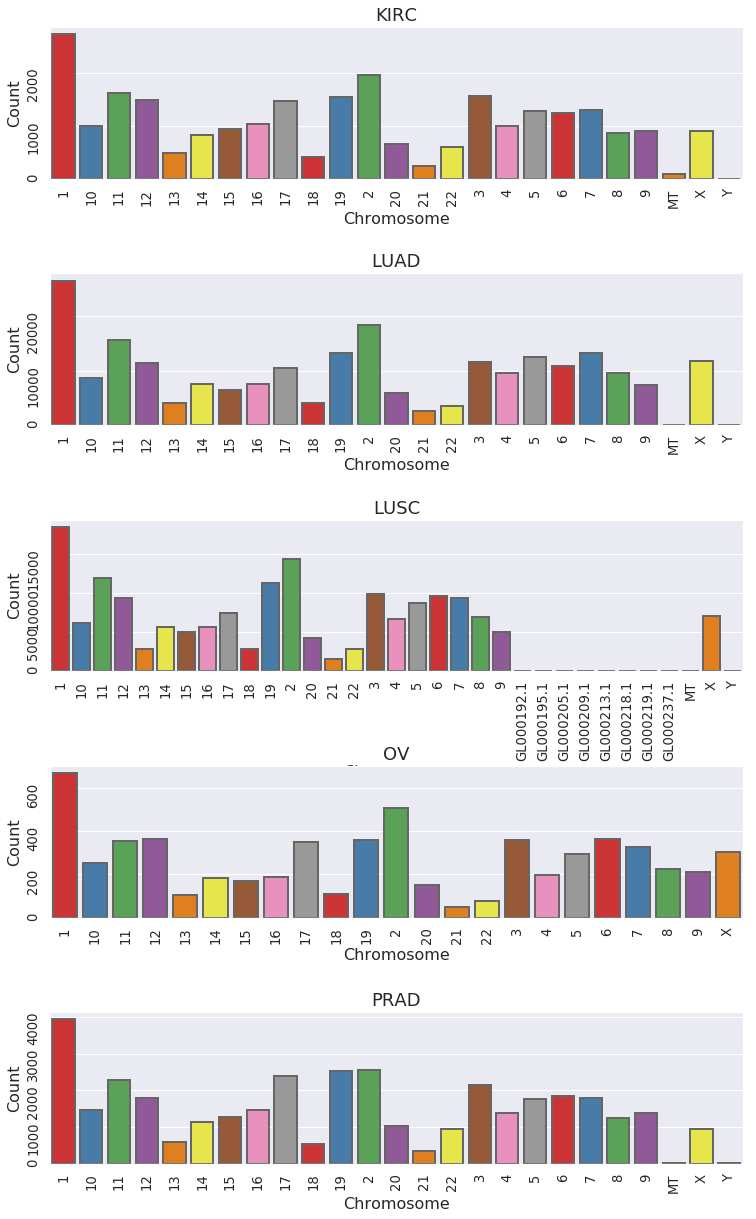

In [7]:
# Visualizing chromosome occurences in barplots
keys = list(mutations.keys())
fig, axes = plt.subplots( nrows=5, ncols=1, figsize=(12, 18) )
fig.tight_layout(pad=4.5)
for i in range(0,5):
    data2plot = mutations.get(keys[i]).groupby("Chrom")["Start_Position"].count()
    sns.barplot(x=data2plot.index, y=data2plot.values, palette="Set1", linewidth=2, edgecolor=".4",  ax=axes[i])
    axes[i].set_xlabel("Chromosome", fontsize=LABEL_SIZE)
    axes[i].set_ylabel("Count", fontsize=LABEL_SIZE)
    axes[i].tick_params(labelrotation=90)
    axes[i].set_title(keys[i], fontsize=TITLE_SIZE)

In [8]:
# Check all the chromosomes occure
chromosomeSet = set()
for key in mutations:
    chromosomeSet = chromosomeSet | set(mutations.get(key)["Chrom"])
    
print("Chromosomes occure in .maf files:")
print(str(chromosomeSet)[1:-1])

Chromosomes occure in .maf files:
'6', 'GL000213.1', '16', '3', '11', '7', 'X', 'GL000209.1', 'GL000195.1', '5', '21', '1', '14', '8', '15', 'GL000219.1', '13', '2', 'GL000218.1', 'GL000237.1', '9', 'MT', '10', 'Y', '12', 'GL000192.1', '22', '4', '18', '19', 'GL000205.1', '20', '17'


According to the results above, we will download only the necessary reference genome and they will be renamed with agreement to .maf files.

### 4) Determining sequence context for an arbitrary genomic position

For the purpose of determining sequence context for an arbitrary genomic position, we will need for reference genome.  It was downloaded from http://hgdownload.cse.ucsc.edu/goldenPath/hg19/chromosomes/. As it is written on the page with the terminal command *"wget --timestamping 'ftp://hgdownload.cse.ucsc.edu/goldenPath/hg19/chromosomes/chrM.fa.gz' -O chrM.fa.gz"* we can get the desired reference genomes, and they can be unziped with the command *"gunzip $<$file$>$.fa.gz"*. The required reference genome files are downloaded and renamed according to the previous results. All the files can be found in the *reference_genome* folder.

To read sequence and get the nucleobase at a given position and its context too a function is defined:
<center>get_sequence_context( chromosomeName, position, numberOfNeighbours, filesPath="./reference_genome" )</center>
This function reads a reference genome file sequentially, and gives back the nucleobase at a given position and its neighbours. Genomic position is defined by the name of the chromosome and the position of the base on that chromosome.

In [9]:
def get_sequence_context( chromosomeName, position, numberOfNeighbours, filesPath="./reference_genome" ):
    
    openedFile = open(filesPath + "/chr" + chromosomeName +".fa", "r")
    
    ch = ""
    while ch != "\n":
        ch = openedFile.read(1)

    i = 0
    while i != position-numberOfNeighbours-1:
        ch = openedFile.read(1)
        if( ch != '\n' ):
            i = i+1
    
    sequenceContext = ""
    i = 0
    while i != 2*numberOfNeighbours + 1:
        ch = openedFile.read(1)
        if( ch != "\n" ):
            sequenceContext = sequenceContext + ch
            i = i + 1
            
    openedFile.close()
    
    return sequenceContext.upper()

In [10]:
# An example sequence context
print("Example sequence:")
print(get_sequence_context("Y",100000,50))

Example sequence:
TGTGTGTGTCCACACTTCCTCTCATGAGAACAGCAGGTTGCTTTAGGGCCCACCCTGACAGCCTCGTTCTAATACTATGAGGCCAAATACACTCACGTTCT


Based on the webpage https://genome-euro.ucsc.edu/cgi-bin/hgTracks?db=hg19&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chr21%3A11111110%2D11111112&hgsid=275840646_e7bSzgLrALdhvWbzVOY8rpBBxySO, we can check if our own get_sequence_context function works properly or not. This happens below for some cases.

In [11]:
# chrY:6736166 -> CAT
print("Correct sequence context: CAT, result of the get_sequence_context function: "
      + get_sequence_context( "Y", 6736166, 1 ))

# chr1:2463579 -> GGC
print("Correct sequence context: GGC, result of the get_sequence_context function: "
      + get_sequence_context( "1", 2463579, 1 ))
      
# chrM:13579 -> TCG
print("Correct sequence context: TCG, result of the get_sequence_context function: "
      + get_sequence_context( "MT", 13579, 1 ))

# chr9:4638293 -> ACC
print("Correct sequence context: ACC, result of the get_sequence_context function: "
      + get_sequence_context( "9", 4638293, 1 ))

# chr21:111111 -> GGT
print("Correct sequence context: GGT, result of the get_sequence_context function: "
      + get_sequence_context( "21", 11111111, 1 ))

Correct sequence context: CAT, result of the get_sequence_context function: CAT
Correct sequence context: GGC, result of the get_sequence_context function: GGC
Correct sequence context: TCG, result of the get_sequence_context function: TCG
Correct sequence context: ACC, result of the get_sequence_context function: ACC
Correct sequence context: GGT, result of the get_sequence_context function: GGT


It may be an interesting question how much time we will need for all the evaluations. In the following I try to estimate it.

In [12]:
# Check required time
positions = [1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e8]
requiredTimes = []
for pos in positions:
    start = time.time()
    get_sequence_context( "1", pos, 1 )
    end = time.time()
    requiredTimes.append(end-start)

In [13]:
# Calculate number of evaluations and average mutation position
totalLength = 0
totalSum = 0
for key in mutations:
    totalLength = totalLength + len(mutations.get(key))
    totalSum = totalSum + mutations.get(key)["Start_Position"].sum()
average = int(totalSum/totalLength)
print("Required number of evaluations: " + str(totalLength))
print("Average mutation position: " + str(average))

Required number of evaluations: 475034
Average mutation position: 81061471


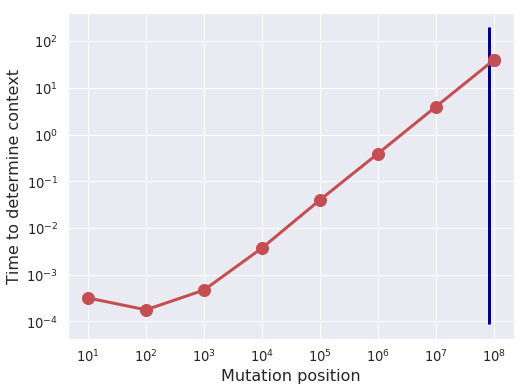

In [14]:
fig, ax = plt.subplots( figsize=(8, 6) )
ax.plot(positions, requiredTimes, 'ro-', markersize=12, linewidth=3, alpha=1.0, label="Measured time" )
ax.vlines(average, 0.5*min(requiredTimes), 5*max(requiredTimes), linewidth=3, color="darkblue")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Mutation position", fontsize=LABEL_SIZE)
ax.set_ylabel("Time to determine context", fontsize=LABEL_SIZE);

As files are read sequentially, required time to find a given position increases linearly with position. This means that totally we would need approximately 166 days to get all necessary sequence context.


It is a crucial question, is there any possibility to make calculations faster? One solution could be the parallelization of calculations. On the other hand I wanted to avoid loading total files into RAM, but it could help too. For example if tasks are sorted based on which file is required, and also tasks are sorted by the required positions, we would be able to determine all sequence context by reading all files only once.

The last task I wanted to carry out until the first report is checking if the base I find by the defined function is the same as the base listed in the Reference_Allele field. Some results can be seen below.

In [15]:
# Checks
toCheck = mutations.get("OV")[12:13]
print("(1)")
print("Expected: " + list(toCheck["Reference_Allele"])[0])
print("Result of get_sequence_context: " + get_sequence_context( list(toCheck["Chrom"])[0] , list(toCheck["Start_Position"])[0], 0 ) )

toCheck = mutations.get("KIRC")[15:16]
print("(2)")
print("Expected: " + list(toCheck["Reference_Allele"])[0])
print("Result of get_sequence_context: " + get_sequence_context( list(toCheck["Chrom"])[0] , list(toCheck["Start_Position"])[0], 0 ) )

toCheck = mutations.get("LUAD")[112:113]
print("(3)")
print("Expected: " + list(toCheck["Reference_Allele"])[0])
print("Result of get_sequence_context: " + get_sequence_context( list(toCheck["Chrom"])[0] , list(toCheck["Start_Position"])[0], 0 ) )

(1)
Expected: G
Result of get_sequence_context: G
(2)
Expected: A
Result of get_sequence_context: A
(3)
Expected: G
Result of get_sequence_context: G


Based on the previous checks we could assume, our function works properly.

### 5) Next steps

- As a next step I will try to increase speed of get_sequence_context function.
- After this I will collect the mutations and categorize them to 96 mutational categories based on the reference and the alternate. For this purpose it is necessary to collect the 96 mutational categories.
- I will create the mutational catalog separately for the 5 different cancer types.
- And until the second report I will do the non-negative matrix factorization too.